In [1]:
from datetime import datetime
print(f"Last updated: {datetime.now().strftime('%Y-%m-%d %I:%M %p')}")

Last updated: 2022-09-16 07:58 AM


# Visualizing Omicron: COVID-19 Deaths vs. Cases

Scroll down for plots for:
- **Africa and the Middle East:** Iran - Israel - South Africa - Tunisia
- **The Americas:** Brazil - Cuba - Canada - Mexico - United States
- **Europe:** Denmark - Germany - Finland - France - Ireland - Italy - Russia - Sweden - United Kingdom
- **South Asia:** India - Pakistan
- **ANZAC:** Australia - New Zealand
- **The World**

**Quality of reporting varies by country;** focus on shape rather than absolute numbers.

See https://github.com/rarnaout/Covidcycles for details and <a href="https://www.researchsquare.com/article/rs-1257935/v1">this preprint</a> for more discussion.

**Citation:** Arnaout, R and Arnaout, R. Visualizing Omicron: COVID-19 Deaths vs. Cases Over Time. 13 January 2022. PREPRINT (Version 2) available at Research Square 
https://doi.org/10.21203/rs.3.rs-1257935/v1

Ramy Arnaout, MD, DPhil / Boston, MA / rarnaout@bidmc.harvard.edu

In [2]:
# %matplotlib notebook

import warnings
warnings.filterwarnings("ignore")  # lzma

from colour import Color
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import matplotlib as mpl
import numpy as np
import pandas as pd

In [3]:
# get data (biweekly smooths the weekly peaks and troughs)
base_url = "https://github.com/owid/covid-19-data/raw/master/public/data/jhu/"
cases  = base_url + "biweekly_cases_per_million.csv"
deaths = base_url + "biweekly_deaths_per_million.csv"
df_cases  = pd.read_csv(cases)
df_deaths = pd.read_csv(deaths)

In [4]:
def plot_deaths_vs_cases(country="United States",
                         variants=False,
                         min_width = 1, max_width = 7,
                         width_scaling = 4, alpha_scaling = 0.5, font_scaling = 0.5,
                         width_between_peaks = 15,
                         last=14, # number of days to plot dots as days
                         fontsize=20,
                         figsize=(6,6),
                         xmax=False,
                         get_data=False, labels=True, time_series=False, save=True, fmt="pdf",
                         from_end=10,
                         rel_height=0.5,
                         ignore_last=0,
                         do_not_plot=False,
                         show=True,
                         dots=True,
                         death_max=False,
                        ):
    # get data (biweekly smooths the weekly peaks and troughs)
#     if get_data:
#         base_url = "https://github.com/owid/covid-19-data/raw/master/public/data/jhu/"
#         cases  = base_url + "biweekly_cases_per_million.csv"
#         deaths = base_url + "biweekly_deaths_per_million.csv"
#         df_cases  = pd.read_csv(cases)
#         df_deaths = pd.read_csv(deaths)
    df = pd.DataFrame({
        "dates": df_cases['date'],
        "cases": df_cases[country],
        "deaths": df_deaths[country]
         })
    df = df.dropna()
    cases  = np.array(list(df.cases))
    deaths = np.array(list(df.deaths))
    dates  = np.array(list(df.dates))
    if do_not_plot:
        cases = cases[:-do_not_plot]
        deaths = deaths[:-do_not_plot]
        dates = dates[:-do_not_plot]    
    first_date = dates[0]
    last_date = dates[-1]
    # L = len(df)
    L = len(cases)
    #    
    # get case peaks; will use to color waves(="loops"="cycles")
    if max(cases) > 50: prominence = (50, float('inf'))
    else:   # special case (China)
        prominence = (10, float('inf'))
        width_between_peaks = 10
    peaks, _ = find_peaks(cases, prominence=prominence, width=width_between_peaks, rel_height=rel_height)
    if len(peaks) == 0: peaks = np.append(peaks, L-1-ignore_last)
    elif L - peaks[-1] > from_end: peaks = np.append(peaks, L-1-ignore_last)  # if no end peak, make the end the peak
    peak_dates = dates[peaks]
    #
    # get troughs between peaks
    troughs, _ = find_peaks(-cases, prominence=(50, float('inf')), width=15) # note minus sign
    pairs_of_peaks = zip(peaks, peaks[1:])
    new_troughs = [0]
    for peak1, peak2 in pairs_of_peaks:
        troughs_between_peaks = []
        for trough in troughs:
            if peak1 < trough < peak2:
                troughs_between_peaks.append(trough)
        troughs_between_peaks = np.array(troughs_between_peaks)
        if len(troughs_between_peaks >= 1):
            trough = min(troughs_between_peaks, key=lambda ii: cases[ii])
        else: continue
        new_troughs.append(trough)
    troughs = new_troughs
    if L-1 not in peaks: troughs.append(L-1)
    troughs = np.array(troughs)
    trough_dates = dates[troughs]
    #
    # set cosmetics
    #     colors
    ref_colors = [ "black", "black", "black", "black", "slategrey", "indigo", "darkblue", "seagreen", "orange", "red"]
    ref_colors = [Color(i) for i in ref_colors]
    last_color = ref_colors.pop()
    inter_trough_widths = troughs[1:] - troughs[:-1]
    if troughs[-1] != L-1:
        inter_trough_widths = np.append(inter_trough_widths, L-troughs[-1])
    colors = []
    for inter_trough_width, color in zip(inter_trough_widths[::-1], ref_colors[::-1]): # note [::-1]
        colors += list(i.hex for i in last_color.range_to(color, inter_trough_width))
        last_color = Color(color)
    colors = colors[::-1]                                                   # reverses [::-1] above
    #     alphas and line widths
    alphas = [(i/L)**alpha_scaling for i in range(L)]
    widths = [(max_width-min_width)*(i/L)**width_scaling+min_width for i in range(L)]
    #
    # create figure
    plt.ion()
    fig_width, fig_height = figsize
    _ = plt.figure(figsize=(fig_width+save*1.5,fig_height))   # hack so labels etc. are in the figure
    #     line
    for i in range(L-1):
        plt.plot(cases[i:i+2], deaths[i:i+2], c=colors[i], linewidth=widths[i], alpha=alphas[i], 
                 solid_capstyle='round', zorder=i)
    #     black dots on each day for `last` period
        plt.scatter(cases[-last:], deaths[-last:], c="black", alpha=alphas[-last:], s=np.array(widths[-last:])/3,
                   zorder=100000)
    #     labels
    if labels == True:
        if not variants: variants = len(peaks)*["",]
        for i, variant in zip(peaks, variants):
            label = f"{dates[i][2:]}"          # formatting for readability
            if not variant.startswith(" "): label += "\n  "
            label += variant
            label = "  " + label.strip()
            plt.text(cases[i], deaths[i], label, fontsize=max(1.1*fontsize*(i/L)**font_scaling, 7), va="center", 
                     color=colors[i], zorder=i, alpha=alphas[i])
    #
    # apply cosmetics
    plt.xlabel("Biweekly cases per million", fontsize=fontsize)
    plt.ylabel("Biweekly deaths per million", fontsize=fontsize)
    plt.title(f"{country} Deaths vs. Cases,\n{first_date} to {last_date}", fontsize=fontsize)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(direction='out', length=10, width=2, labelsize=fontsize)
    ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    
    if xmax:
        xmin, current_xmax = ax.get_xlim()
        if xmax >= current_xmax:
            ax.set_xlim(xmin, xmax)
    if save:
        plt.tight_layout()
        _ = plt.savefig(f"Hi-res_country_plots/{country}_{dates[-1]}.{fmt}", transparent=True, format=fmt)
    if show:
        plt.show()
    
    # optionally, also plot time series
    if time_series:
        # plot cases vs. time
        plt.figure(figsize=(figsize[0],3))
        for i in range(L-1):
            plt.plot(dates[i:i+2], cases[i:i+2], c=colors[i], linewidth=widths[i], alpha=alphas[i])
        if dots:
            plt.scatter(peak_dates, cases[peaks], c="tab:orange")
            plt.scatter(trough_dates, cases[troughs], c="tab:red")
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.tick_params(direction='out', length=10, width=2, labelsize=fontsize)
        plt.xticks(dates[::200])
        plt.title(f"{country}, Cases vs. Time,\n{dates[0]} to {dates[-1]}", fontsize=fontsize)
        plt.ylabel("Cases", fontsize=fontsize)
        plt.show()
        # plot deaths vs. time
        plt.figure(figsize=(figsize[0],3))
        for i in range(L-1):
            plt.plot(dates[i:i+2], deaths[i:i+2], c=colors[i], linewidth=widths[i], alpha=alphas[i])
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.tick_params(direction='out', length=10, width=2, labelsize=fontsize)
        plt.xticks(dates[::200])
        plt.title(f"{country}, Deaths vs. Time,\n{dates[0]} to {dates[-1]}", fontsize=fontsize)
        if death_max:
            plt.ylim([0, death_max])
        plt.ylabel("Deaths", fontsize=fontsize)
        if show: plt.show()        
    
    return

Let's look at some examples. 

In all the plots:

- the most recent wave is red, 
- the previous wave is green, 
- the one before that is blue, 
- the one before that is purple, and
- any wave prior to that is gray.

The line thickens and darkens as it approaches the present day, and the label font gets bigger.

Note the differences in scale from plot to plot.

<a id='country_plots'></a>

# Africa and the Middle East

## South Africa

South Africa had one of the earliest omicron waves.

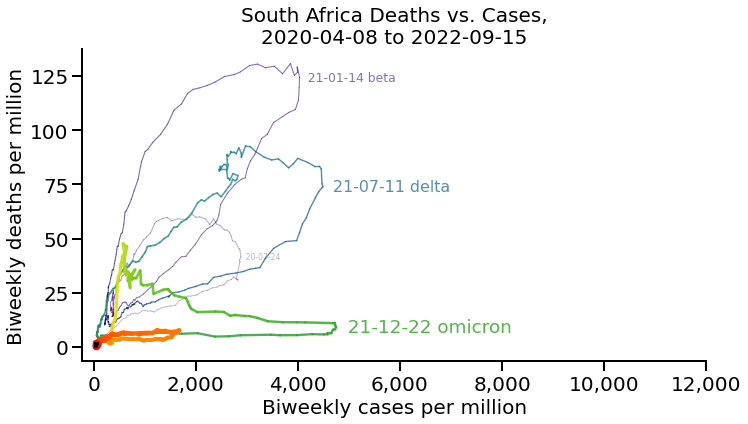

In [5]:
plot_deaths_vs_cases("South Africa", variants=["", " beta", " delta", " omicron"], figsize=(9,6), xmax=12000, last=21)

A black dot marks each day of the past 2-3 weeks.

Note the counterclockwise loops. Cases rise, then deaths rise, then cases fall, and finally deaths fall.

Original (purple), beta (blue), delta (green), and omicron (red) waves are clearly visible. Two mid-summer peaks, two mid-winter peaks.

The shape and area of each loop indicate the lag time between getting sick and dying, and also the deadliness of each wave.

220-01-14: Has uptick resolved?

22-01-13: The uptick at the end of what was earlier described as the resolution of the omicron wave bears watching.

## Israel

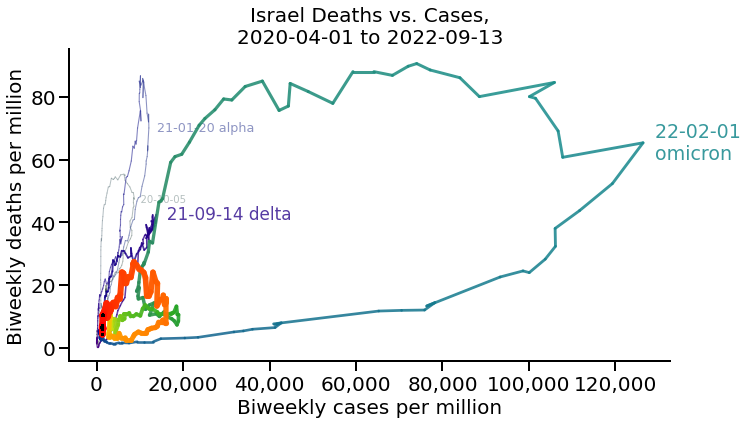

In [6]:
plot_deaths_vs_cases("Israel", variants=["", " alpha", " delta", "omicron"], figsize=(9,6), xmax=40000, ignore_last=11)

22-02-03: High deaths, following the delay, for the latest loop. Contrast to South Africa

22-01-30: First omicron wave appears to be peaking. Low deaths per case (flat loop), but high absolute number of deaths.

22-01-13: Omicron deaths are quite low. As with South Africa, note the flattening of subsequent waves, indicating progressive fall in case mortality. The space between the last few dots shows the pace of omicron.

## Tunisia

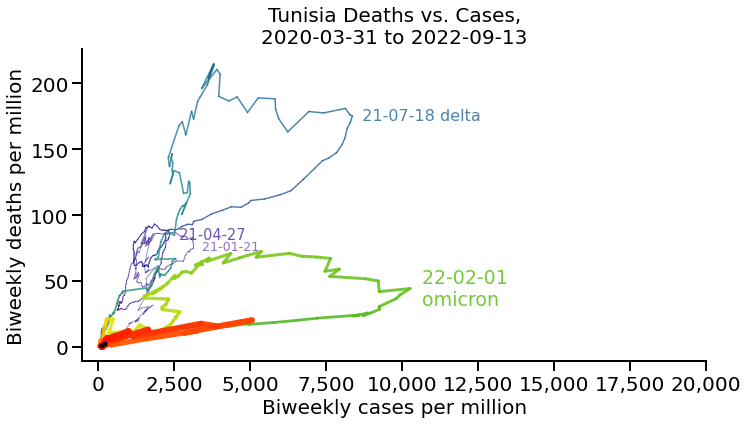

In [7]:
plot_deaths_vs_cases("Tunisia", variants=["", "", " delta", "omicron"], figsize=(9,6), xmax=20000, ignore_last=11)

22-01-13: Omicron not yet reported per <a href="https://covariants.org/per-country">CoVariants.org</a> but seems likely.

## Iran

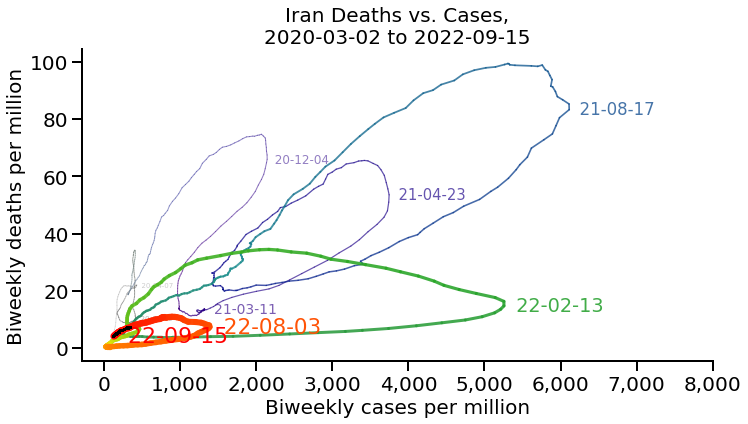

In [8]:
plot_deaths_vs_cases("Iran", variants=[], figsize=(9,6), xmax=8000)

22-01-13: The 20-12-04 loop did not close; suspect reporting artifact (e.g. underreporting of cases as this wve started). Omicron was reported in Iran in December 2021.

# The Americas

## United States

Testing (and therefore the number of cases) has remained difficult to get and deaths have remained stubbornly high in the United States.

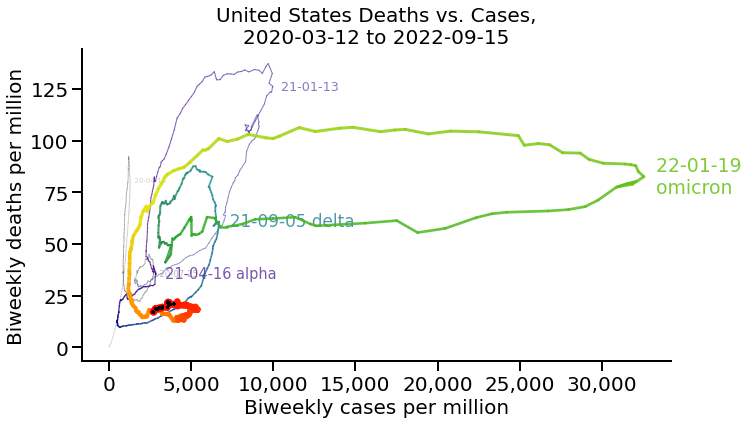

In [9]:
plot_deaths_vs_cases("United States", variants=["", "", "", " alpha", " delta", "omicron"], figsize=(9,6), last=21)#, time_series=True)

22-01-13: The omicron wave has begun quite differently from previous waves. Hopefully it resolves as South Africa's has so far.

## Canada

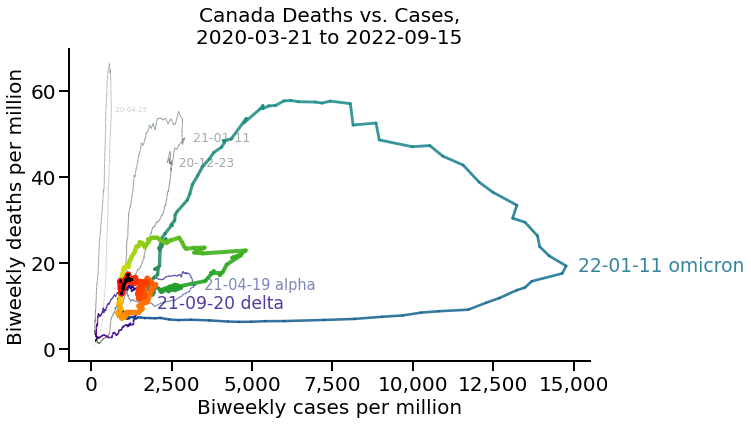

In [10]:
plot_deaths_vs_cases("Canada", variants=["", "", "", " alpha", " delta", " omicron"], figsize=(9,6), last=21, rel_height=1.5)#, time_series=True)

220-01-30: Quite a rise in death rate.

220-01-15: Quebec is asking non-priority groups to take rapid tests instead of PCR tests. Rapid tests are less sensitive. Does that account for the sharp but temporary fall in casess around 22-01-11?

220-01-14: Will uptick resolve as seems to be the case with South Africa? Could reflect delay between *delta* hospitalizations and deaths?

22-01-13: Similar dynamics to its neighbor to the south, but fewer cases and deaths per million. Has omicron peaked? I would have imagined a tighter clustering of dots at the peak, but it's possible.

## Mexico

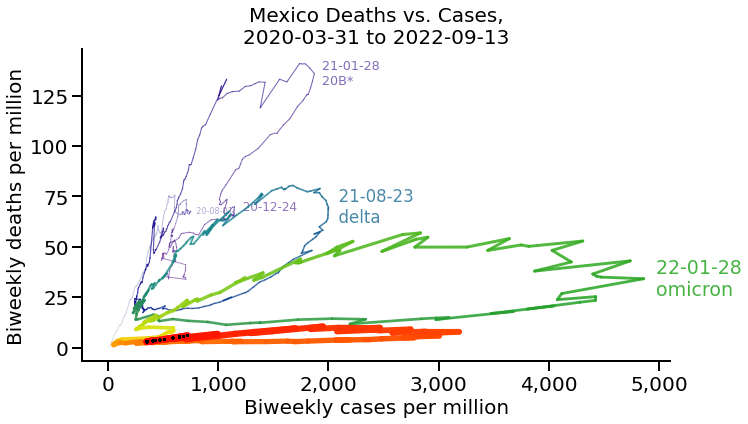

In [11]:
plot_deaths_vs_cases("Mexico", variants=["", "", "20B*", "delta", "omicron"], figsize=(9,6))#, time_series=True)

220-01-30: First omicron wave appears to be peaking.

22-01-13: \*20B was 0.47. Progressive flattening of the loops is reminiscent of South Africa/Israel.

## Cuba

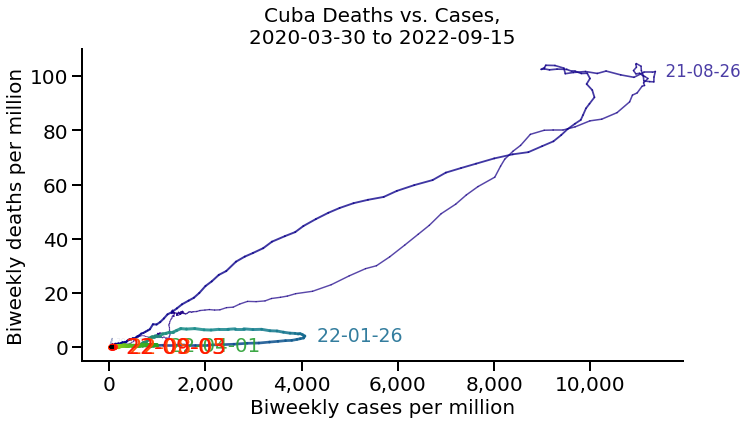

In [12]:
plot_deaths_vs_cases("Cuba", figsize=(9,6), ignore_last=12)#, time_series=True)

220-01-30: Wave appears to be peaking. >90% fully vaccinated. No variant data at Covariants.

22-01-13: <a href="https://ourworldindata.org/covid-vaccinations">86% fully vaccinated</a> as of January 11, 2022.

## Brazil

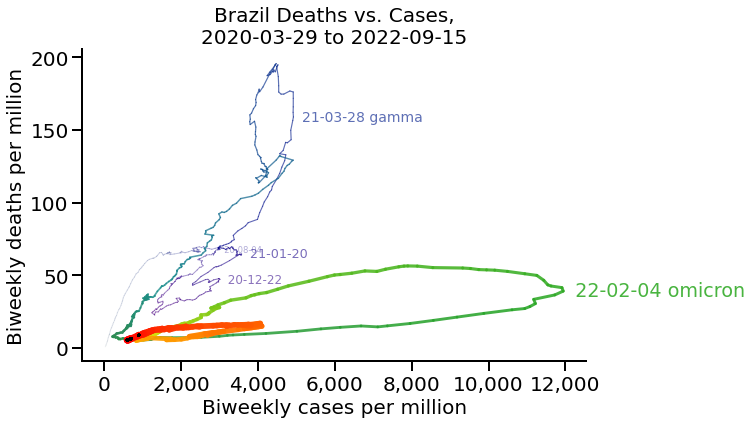

In [13]:
plot_deaths_vs_cases("Brazil", variants=["", "", "", " gamma", " omicron"], figsize=(9,6))#, time_series=True)

22-01-13: Gamma predominated in March 2021.

# Europe

## Italy

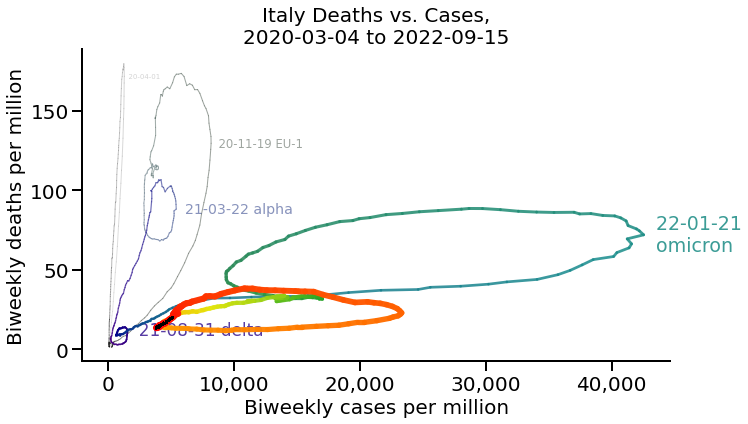

In [14]:
plot_deaths_vs_cases("Italy", variants=["", " EU-1", " alpha", " delta", "omicron"], figsize=(9,6))

22-01-13: Famously hard-hit in the first wave. Note the April 2021 resurgence before the December 2020 peak had fully resolved, and how differently omicron has begun.

## France

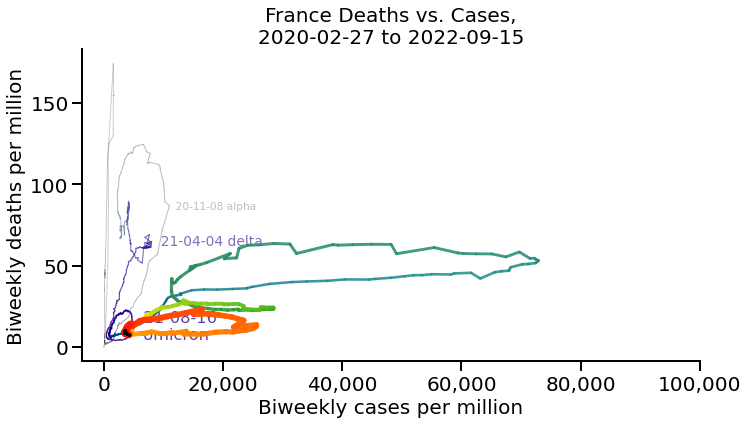

In [15]:
plot_deaths_vs_cases("France", variants=[" alpha", " delta", "omicron"], figsize=(9,6), xmax=100000) #, time_series=True, dots=True, death_max=300)

22-01-13: Similar to Italy.

## Denmark

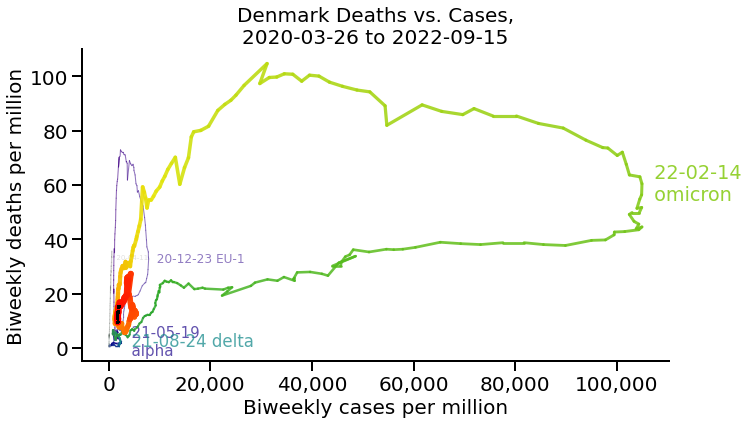

In [16]:
plot_deaths_vs_cases("Denmark", variants=["", " EU-1", "alpha", " delta", "omicron"], figsize=(9,6), ignore_last=10, dots=False, death_max=100)

22-01-13: A lot of virus sequencing in Denmark. A relatively quiet pandemic until omicron. The inflection point as the curve goes from orange to red marked the transition from delta to omicron (not labeled here).

## United Kingdom

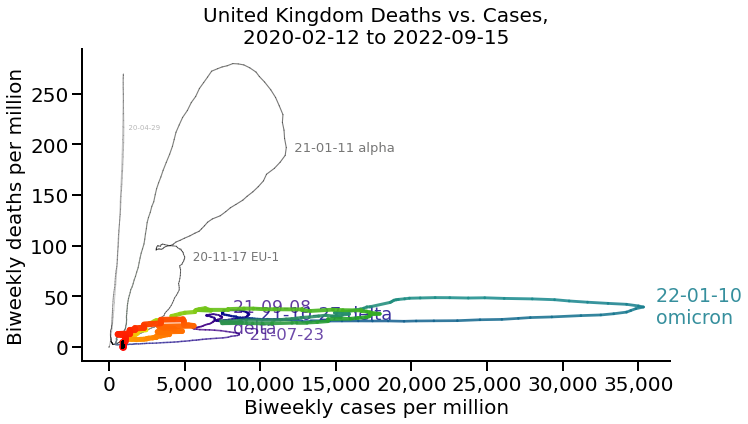

In [17]:
plot_deaths_vs_cases("United Kingdom", variants=["", " EU-1", " alpha", "", "delta", " delta", "omicron"], figsize=(9,6), rel_height=0.6)#, time_series=True)

22-01-13: A relatively mild delta wave. The density of the black dots around 22-01-12 is notable. Is the UK's omicron wave peaking?

## Ireland

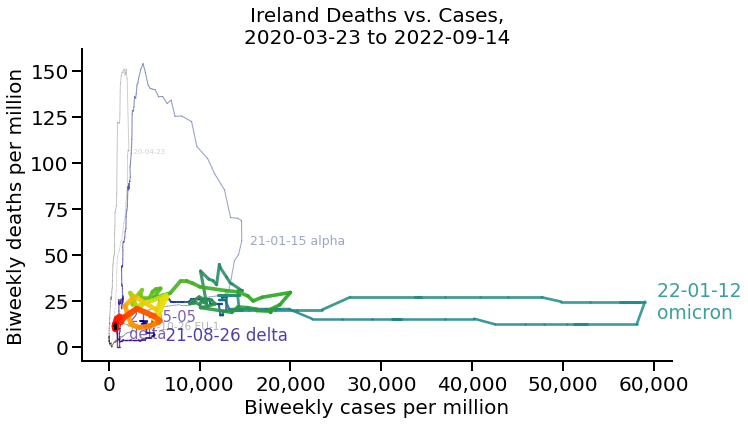

In [18]:
plot_deaths_vs_cases("Ireland", variants=["", " EU-1", " alpha", "delta", " delta", "omicron"], figsize=(9,6))#, time_series=True)

22-01-13: Same question: is omicron peaking?

## Sweden

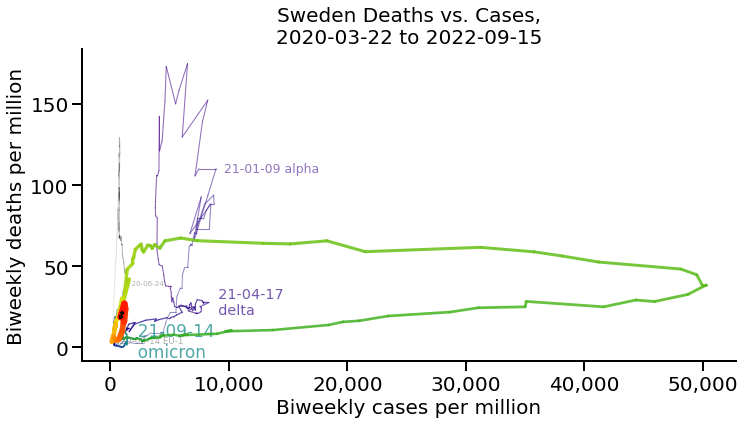

In [19]:
plot_deaths_vs_cases("Sweden", variants=["", " EU-1", " alpha", "delta", "omicron"], figsize=(9,6), xmax=25000)#, time_series=True)

22-01-13: Famously an outlier in its early approach. The spikiness suggests to me a data-reporting issue. A spike in April 2021. Omicron spreading rapidly with much less of an increase in death rate relative to a year before.

## Germany

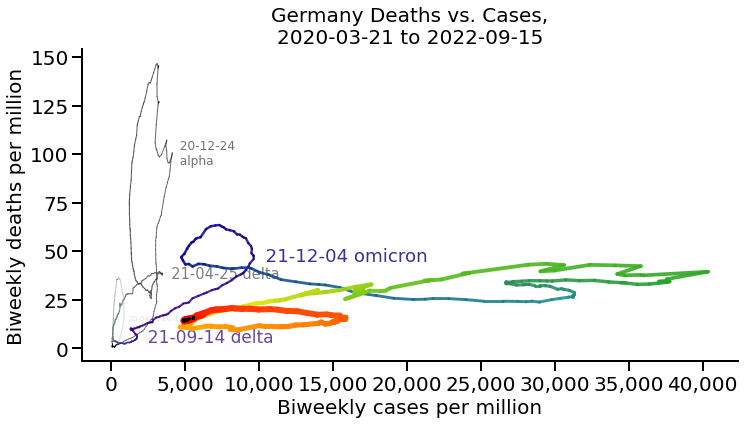

In [20]:
plot_deaths_vs_cases("Germany", variants=[" EU-1", "alpha", " delta", " delta", " omicron"], figsize=(9,6))#, time_series=True)

22-01-13: The second-most populous European country. Fewer loops, but again a dramatic difference in loop orientation, illustrating much different effect. Omicron only recently reported. Expect it to follow the Netherlands' trajectory.

## Netherlands

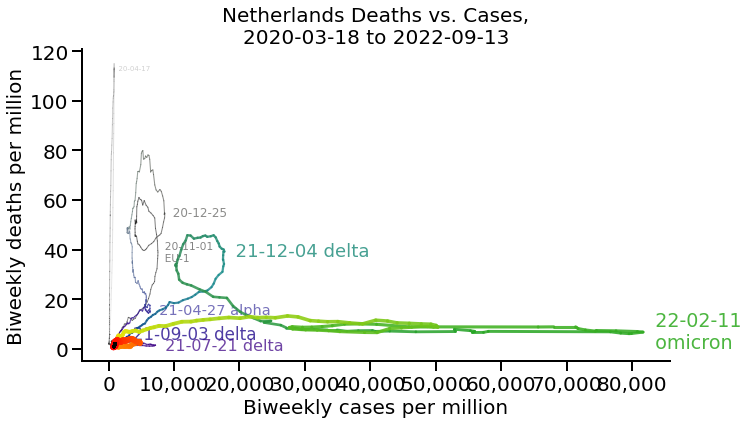

In [21]:
plot_deaths_vs_cases("Netherlands", variants=["", "EU-1", "", " alpha", " delta", " delta", " delta", "omicron"], figsize=(9,6), ignore_last=10)#, time_series=True)

22-01-13: Good reporting. Dynamics similar to Germany's. Multiple delta waves. Death rate falling as omicron spreads.

## Finland

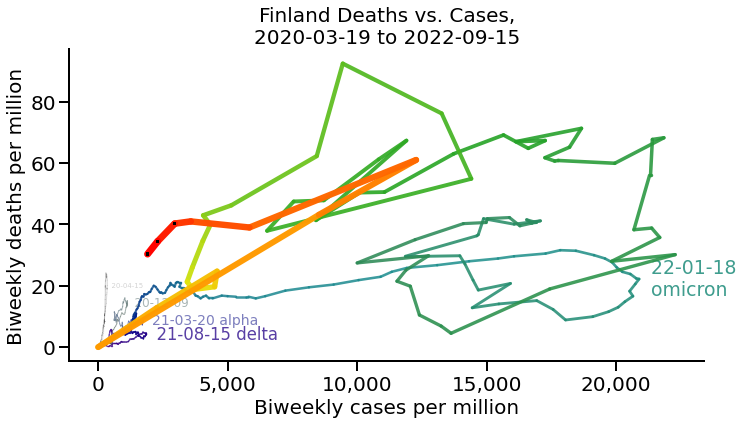

In [22]:
plot_deaths_vs_cases("Finland", variants=["", "", " alpha", " delta", "omicron"], figsize=(9,6))#, time_series=True, dots=False, ignore_last=10)

220-01-30: Clockwise loop continues. Another peak to come?

22-01-26: A *clockwise* omicron loop: more deaths earlier. Leftovers from delta?

22-01-13: Omicron is the deadliest wave yet.

## Russia

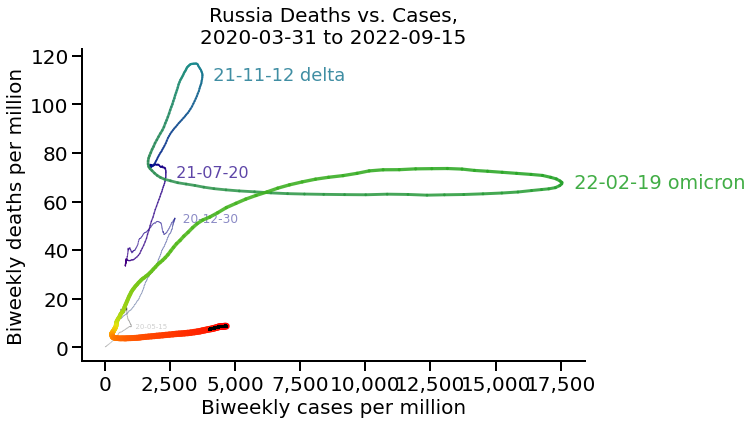

In [23]:
plot_deaths_vs_cases("Russia", variants=["", "", "", " delta", " omicron"], figsize=(9,6), ignore_last=10)#, time_series=True)

22-01-13: Unusual: per this reporting, each wave worse than the last.

# Far East

## Japan

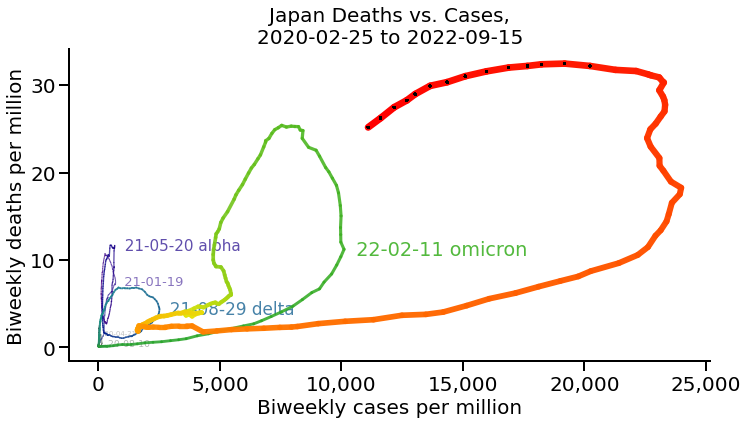

In [24]:
plot_deaths_vs_cases("Japan", variants=["", "", "", " alpha", " delta", " omicron"], figsize=(9,6), ignore_last=8)#, time_series=True)

22-01-13: The August 2021 peak saw many more cases but many fewer deaths than the two previous ones. What changed for Japan between May and August? The omicron wave has just begun.

## South Korea

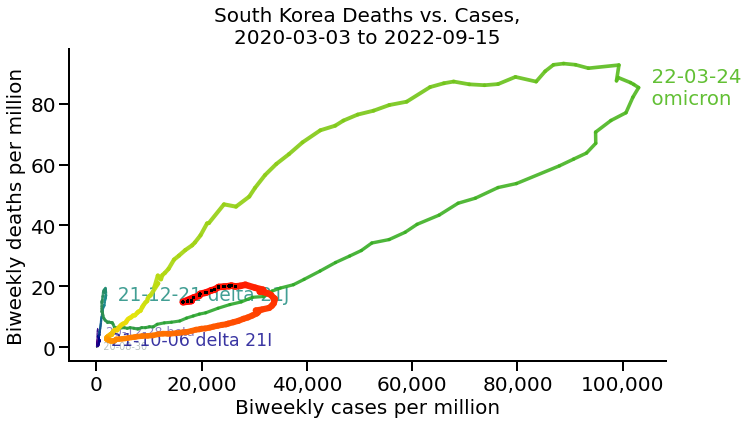

In [25]:
plot_deaths_vs_cases("South Korea", variants=["", " beta", " delta 21I", " delta 21J", "omicron"], figsize=(9,6))#, time_series=True)

22-01-13: Quite a different trajectory to its neighbors, but this is still delta. South Korea may well follow the Netherlands and Germany. The stasis around 21-01-12 suggests a new wave is about to start.

## China

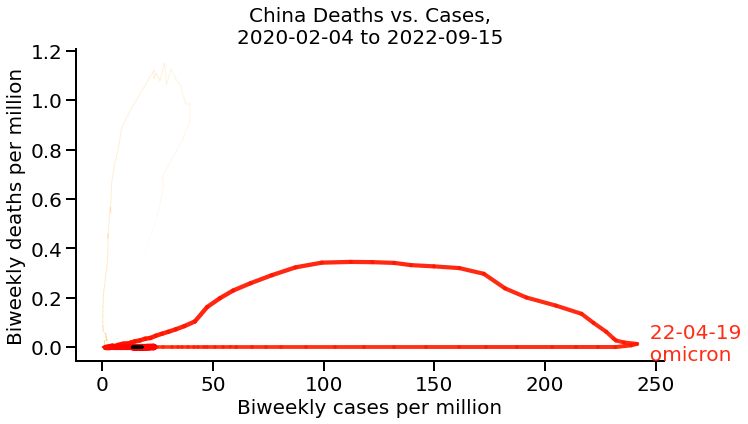

In [26]:
plot_deaths_vs_cases("China", variants=["omicron"], figsize=(9,6), xmax=40)

22-01-13: A zero-COVID policy. Not much reported. Note the axis units.

# South Asia

## India

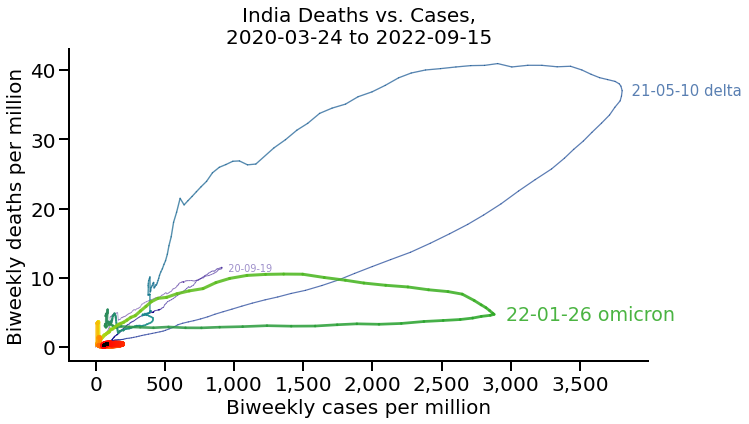

In [27]:
plot_deaths_vs_cases("India", variants=["", " delta", " omicron"], figsize=(9,6))#, time_series=True)

The second-most populous country.

## Pakistan

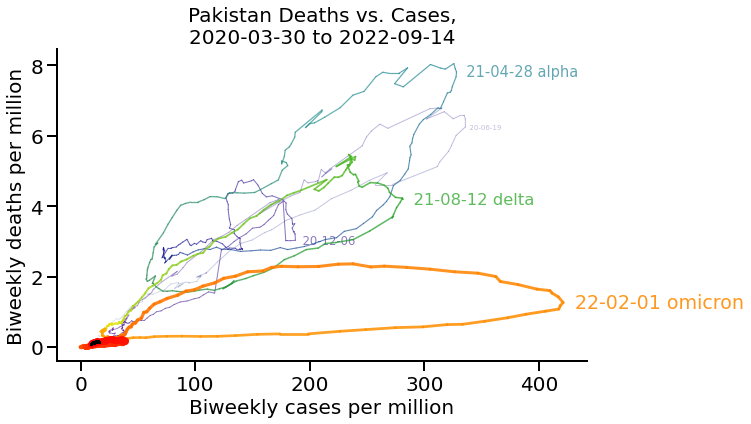

In [28]:
plot_deaths_vs_cases("Pakistan", variants=["", "", " alpha", " delta", " omicron"], figsize=(9,6))#, time_series=True)

22-01-13: Less flattening than in other countries with low vaccination rates, but lower peak death rate from delta, as seen elsewhere.

# ANZAC

## Australia

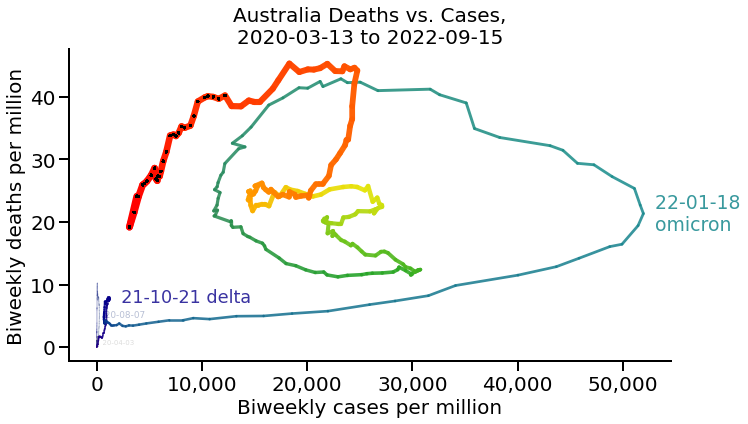

In [29]:
plot_deaths_vs_cases("Australia", variants=["", "", " delta", "omicron"], figsize=(9,6), last=30)#, time_series=True)

220-01-30: Quite a rise in death rate.

22-01-13: Another country with tight controls for most of the pandemic. In January 2021 Australia decided omicron was uncontainable. The space between the dots indicates the very rapid spread of omicron.

## New Zealand

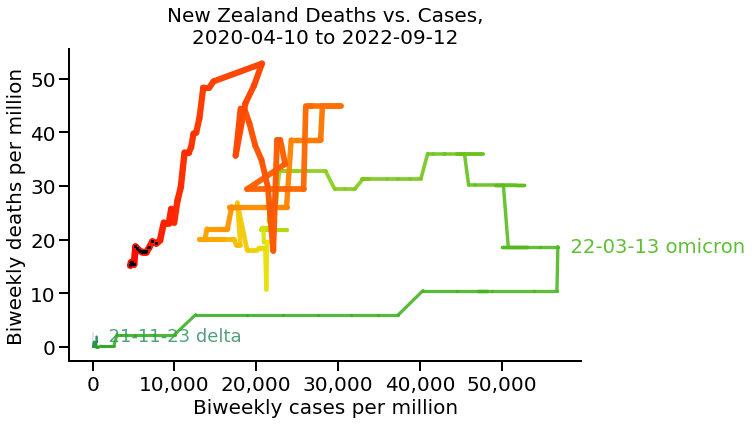

In [30]:
plot_deaths_vs_cases("New Zealand", variants=[" delta", " omicron"], figsize=(9, 6))#, time_series=True)

Small, distant, tight controls, unified populace, distinctive trajectories.

# World

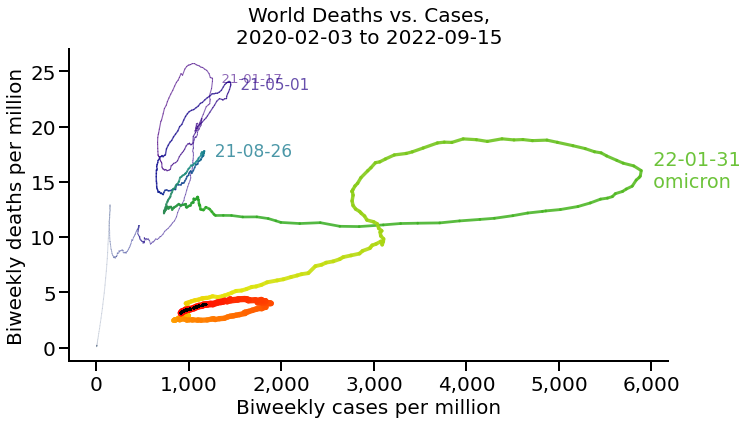

In [31]:
plot_deaths_vs_cases("World", variants=["", "", "", "omicron"], save=True, figsize=(9,6))#, time_series=True)

220-01-30: This first omicron wave is peaking around the world.